# News Data Sentiment Classifier

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import dill
import re
from collections import Counter
from tqdm.notebook import tqdm, trange
import random

C:\Users\avila\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing `nltk`'s VADER Pre-trained Sentiment Classifier as a first working model.

In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOP_WORDS = stopwords.words('english')

from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')
SIA = SentimentIntensityAnalyzer()
# for scores, call the SIA.polarity_scores method()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\avila\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avila\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [4]:
abbv_news = dill.load(open('ABBV.pkd', 'rb'))
adxs_news = dill.load(open('ADXS.pkd', 'rb'))
agen_news = dill.load(open('AGEN.pkd', 'rb'))
agio_news = dill.load(open('AGIO.pkd', 'rb'))
amgn_news = dill.load(open('AMGN.pkd', 'rb'))
aveo_news = dill.load(open('AVEO.pkd', 'rb'))
azn_news = dill.load(open('AZN.pkd', 'rb'))
bmy_news = dill.load(open('BMY.pkd', 'rb'))
clvs_news = dill.load(open('CLVS.pkd', 'rb'))
exel_news = dill.load(open('EXEL.pkd', 'rb'))

news = [abbv_news, adxs_news, agen_news, agio_news,
        amgn_news, aveo_news, azn_news, bmy_news, 
        clvs_news, exel_news]

companies = ["Abbvie Inc.", "Advaxis Inc.", "Agenus Inc.",
             "Agios Pharmaceutical Inc.", "Amgen Inc.",
             "Aveo Pharmaceuticals Inc.", "AstraZeneca PLC",
             "Bristol-Myers Squibb Co.", "Clovis Oncology Inc.",
             "Exelixis Inc."]

### Data Preprocessing

In [5]:
def clean_title(text):
    """Removes the news format from text."""
    for news_type in {'News:', 'Press Release:'}:
        if news_type in text:
            return text.lstrip(news_type+' ')
    
def transformer(sentence):
    """Remove stop words and punctuation from sentence."""
    tokens = sentence.split(" ")
    tokens_filtered = [word for word in tokens if not word in (list(STOP_WORDS) or punctuation)]
    return (" ").join(tokens_filtered)

In [6]:
# combine all news into a single series
all_news = pd.concat([df.text for df in news], ignore_index=True)
# clean the news formats
all_news = all_news.apply(clean_title)
all_news = all_news.apply(transformer)
all_news

0        isankizumab (SKYRIZI®) Demonstrates Significan...
1        AbbVie Present 39th Annual J.P. Morgan Healthc...
2        isankizumab (SKYRIZI®) Phase 3 Results Demonst...
3        AbbVie Announces Risankizumab Demonstrates Sig...
4        AbbVie Says Risankizumab Phase 3 Results Demon...
                               ...                        
17749    Data Presented AACR -- IASLC Conference Molecu...
17750                                  Exelixis Calls Sold
17751    BIO Announces Initial Companies Selected Prese...
17752    Exelixis Announces January 12 Webcast Presenta...
17753    Benzinga’s Top Pre- Market Losers (ADSK, CNQR,...
Name: text, Length: 17754, dtype: object

#### Scoring Metrics

In [7]:
def region_score(score):
    """Takes in a polarity_scores dictionary."""
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    
    if neg < np.log(0.5*(pos+2)):
        return 1 # positive news
    elif (neg > np.log(0.5*(pos+2)) and neg < pos) or (neu <= 0.5):
        return 0 # neutral news
    elif neg > pos:
        return -1 # negative news
    return 0 # nill category news
     
    
def mixed_score(score):
    """Takes in a polarity_scores dictionary."""
    x = score['compound']
    
    kinds = {'neutral': round(np.sin(0.5*np.pi*x)),
             'critical': round(2/(1+(1/3)**(50*x))-1)
            }
    
    return kinds

# Post Scoring: EDA & Feature Analysis

In [8]:
df = pd.DataFrame({'Headline': all_news})
df['region'] = pd.Series([region_score(SIA.polarity_scores(head))
                          for head in tqdm(all_news)])
for x in ['neutral', 'critical']:
    df[x] = pd.Series([mixed_score(SIA.polarity_scores(head))[x] 
                       for head in tqdm(all_news)])
df.head()

  0%|          | 0/17754 [00:00<?, ?it/s]

  0%|          | 0/17754 [00:00<?, ?it/s]

  0%|          | 0/17754 [00:00<?, ?it/s]

,Headline,region,neutral,critical
0,isankizumab (SKYRIZI®) Demonstrates Significan...,1,1,1
1,AbbVie Present 39th Annual J.P. Morgan Healthc...,0,0,0
2,isankizumab (SKYRIZI®) Phase 3 Results Demonst...,1,0,1
3,AbbVie Announces Risankizumab Demonstrates Sig...,1,1,1
4,AbbVie Says Risankizumab Phase 3 Results Demon...,1,0,1


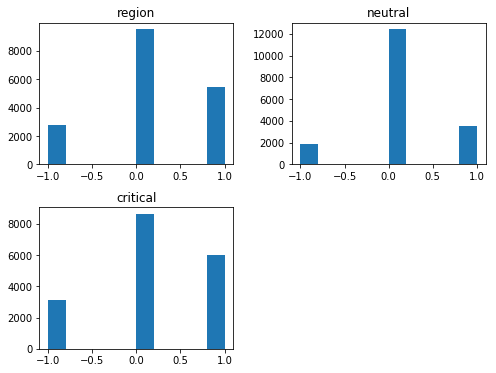

In [14]:
df[list(df.columns)[1:]].hist(grid=False, figsize=(8,6));

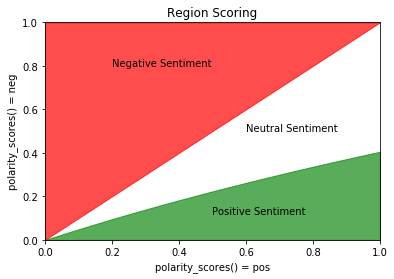

In [11]:
# =============================================================== #
# SIA.polarity_scores() outputs a dictionary of positive/negative
# sentiment. Apply region_scoring based on the following rule.
# Score determined by where (pos,neg) lands on the below diagram.
# =============================================================== #
x_arr = np.linspace(0,1)
plt.figure()
plt.title('Region Scoring')
plt.xlabel('polarity_scores() = pos')
plt.ylabel('polarity_scores() = neg')

plt.fill_between(x_arr, 1, x_arr, color='r', alpha=0.7)
plt.fill_between(x_arr, np.log(0.5*(x_arr+2)), color='green', alpha=0.65)
plt.axis([0,1,0,1])

plt.annotate('Negative Sentiment', (0.2,0.8))
plt.annotate('Neutral Sentiment', (0.6,0.5))
plt.annotate('Positive Sentiment', (0.5,0.12))

plt.show();

In [10]:
df[list(df.columns)[1:]].value_counts()

region  neutral  critical
 0       0        0          8638
 1       1        1          3443
         0        1          2018
-1      -1       -1          1665
         0       -1          1125
 0       0        1           456
        -1       -1           169
         0       -1           149
         1        1            78
-1       0        1             7
                  0             6
dtype: int64

## To Update:

- Create a set of positive features and a set of negative features.

In [ ]:
filenames = ['common_adjectives.csv', 'common_adverbs.csv',
             'common_nouns.csv', 'common_verbs.csv', 'random_words.csv']

# sentiment truths
word_truths = pd.concat([pd.read_csv(file) for file in filenames],
                        ignore_index=True)

positive_words = word_truths[word_truths.Sentiment == 1].Word.unique()
negative_words = word_truths[word_truths.Sentiment == -1].Word.unique()
# these are to be removed from the corpus
neutral_words = word_truths[word_truths.Sentiment == 0].Word.unique()

def word_feats(words):
    return dict([(word, True) for word in words])

positive_features = [(word_feats(pos), 'pos') for pos in positive_words]
negative_features = [(word_feats(neg), 'neg') for neg in negative_words]
neutral_features = [(word_feats(neut), 'neu') for neut in neutral_words]

- Use these words to train a `NaiveBayesClassifier`
    - do a binary sentiment classification of headlines
- Use a split of the sentences that scored `(111)` or `(-1-1-1)` as the train set
    - Test model on the `(111)` and `(-1-1-1)` headlines
- Once model is functional, classify the neutral headlines which scored `(000)`
    - classify all other sentences with other variations of the inital scores